# House price prediction [🔗](https://www.kaggle.com/competitions/home-data-for-ml-course/data)
by kaggle

## Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression

# Approach
1. Load data
2. Create new features
3. Check Mutual Information
4. Select useful features
5. Extract numerical and categorical features
6. Create Pipeline
7. Do hyperparameter tuning with cross-validation
8. Check MAE, select best parameters
9. Train model on best parameters
10. Predict prices on `test_data`
11. Submit predictions

## 1. Load data

In [3]:
house_data = pd.read_csv("../input/home-data-for-ml-course/train.csv", index_col="Id")
test_data = pd.read_csv("../input/home-data-for-ml-course/test.csv", index_col="Id")

pd.set_option("display.max_columns", house_data.shape[1])
house_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Creating new features

In [4]:
house_data["Spaciousness"] = house_data[["1stFlrSF", "2ndFlrSF"]].sum(axis=1) / house_data.TotRmsAbvGrd

In [5]:
house_data["LivLotRatio"] = house_data["GrLivArea"] / house_data["LotArea"]

In [6]:
house_data["TotalOutsideSF"] = house_data[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "GarageArea"]].sum(axis=1)

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

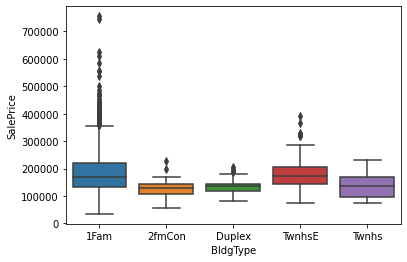

In [7]:
sns.boxplot(x="BldgType", y="SalePrice", data=house_data)

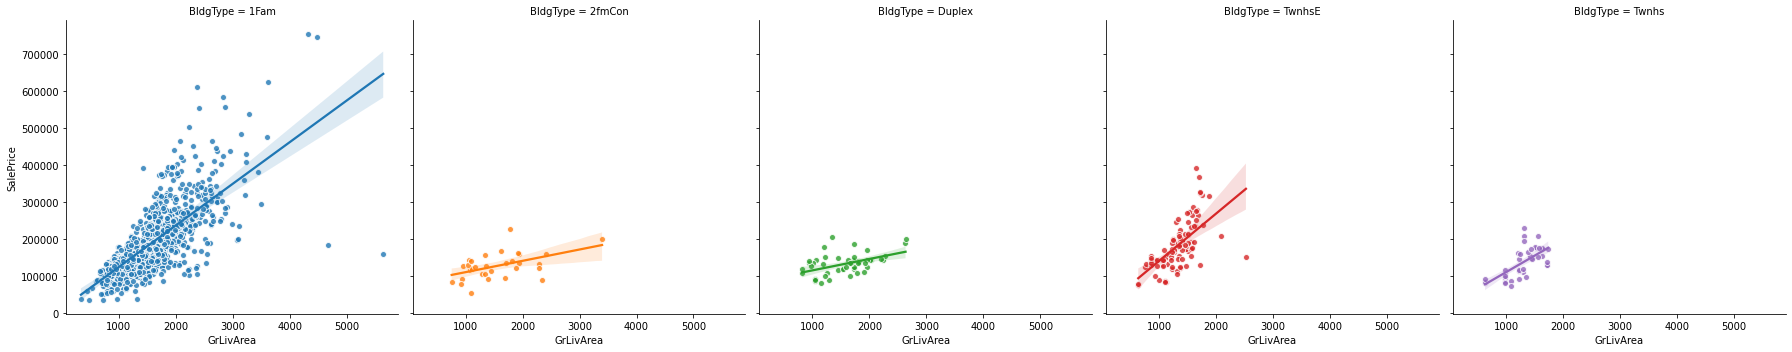

In [8]:
sns.lmplot(x="GrLivArea", y="SalePrice", hue="BldgType", col="BldgType",
           data=house_data, scatter_kws={"edgecolor": 'w'},
          )

In [9]:
# Categorical and numerical col relation
x = pd.get_dummies(house_data["BldgType"], prefix="Bldg")
# Multiply
x = x.mul(house_data["GrLivArea"], axis=0)
house_data = house_data.join(x)

In [10]:
def show_data(data):
    pd.set_option("display.max_columns", data.shape[1])
    return data

In [11]:
show_data(house_data)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Spaciousness,LivLotRatio,TotalOutsideSF,Bldg_1Fam,Bldg_2fmCon,Bldg_Duplex,Bldg_Twnhs,Bldg_TwnhsE
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,213.750000,0.202367,609,1710,0,0,0,0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,210.333333,0.131458,758,1262,0,0,0,0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,297.666667,0.158756,650,1786,0,0,0,0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,245.285714,0.179791,949,1717,0,0,0,0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,244.222222,0.154137,1112,2198,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,235.285714,0.208033,500,1647,0,0,0,0
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,296.142857,0.157343,849,2073,0,0,0,0
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,No

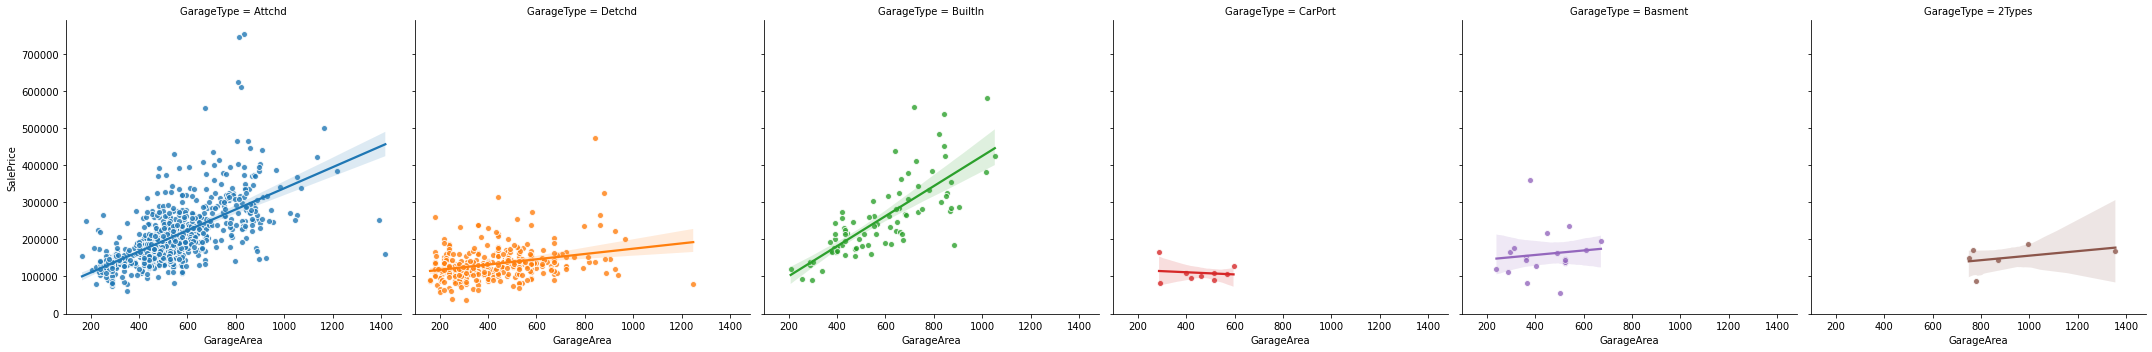

In [12]:
sns.lmplot(x="GarageArea", y="SalePrice", hue="GarageType", col="GarageType",
           data=house_data, scatter_kws={"edgecolor": 'w'},
          )

In [13]:
# Categorical and numerical col relation
x = pd.get_dummies(house_data["GarageType"], prefix="Garage")
# Multiply
x = x.mul(house_data["GarageArea"], axis=0)
house_data = house_data.join(x)

In [14]:
show_data(house_data)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Spaciousness,LivLotRatio,TotalOutsideSF,Bldg_1Fam,Bldg_2fmCon,Bldg_Duplex,Bldg_Twnhs,Bldg_TwnhsE,Garage_2Types,Garage_Attchd,Garage_Basment,Garage_BuiltIn,Garage_CarPort,Garage_Detchd
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,213.750000,0.202367,609,1710,0,0,0,0,0,548,0,0,0,0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,210.333333,0.131458,758,1262,0,0,0,0,0,460,0,0,0,0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,297.666667,0.158756,650,1786,0,0,0,0,0,608,0,0,0,0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,245.285714,0.179791,949,1717,0,0,0,0,0,0,0,0,0,642
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,244.222222,0.154137,1112,2198,0,0,0,0,0,836,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,235.285714,0.208033,500,1647,0,0,0,0,0,460,0,0,0,0
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min

In [15]:
house_data["PorchTypes"] = house_data[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]].gt(0).sum(axis=1)

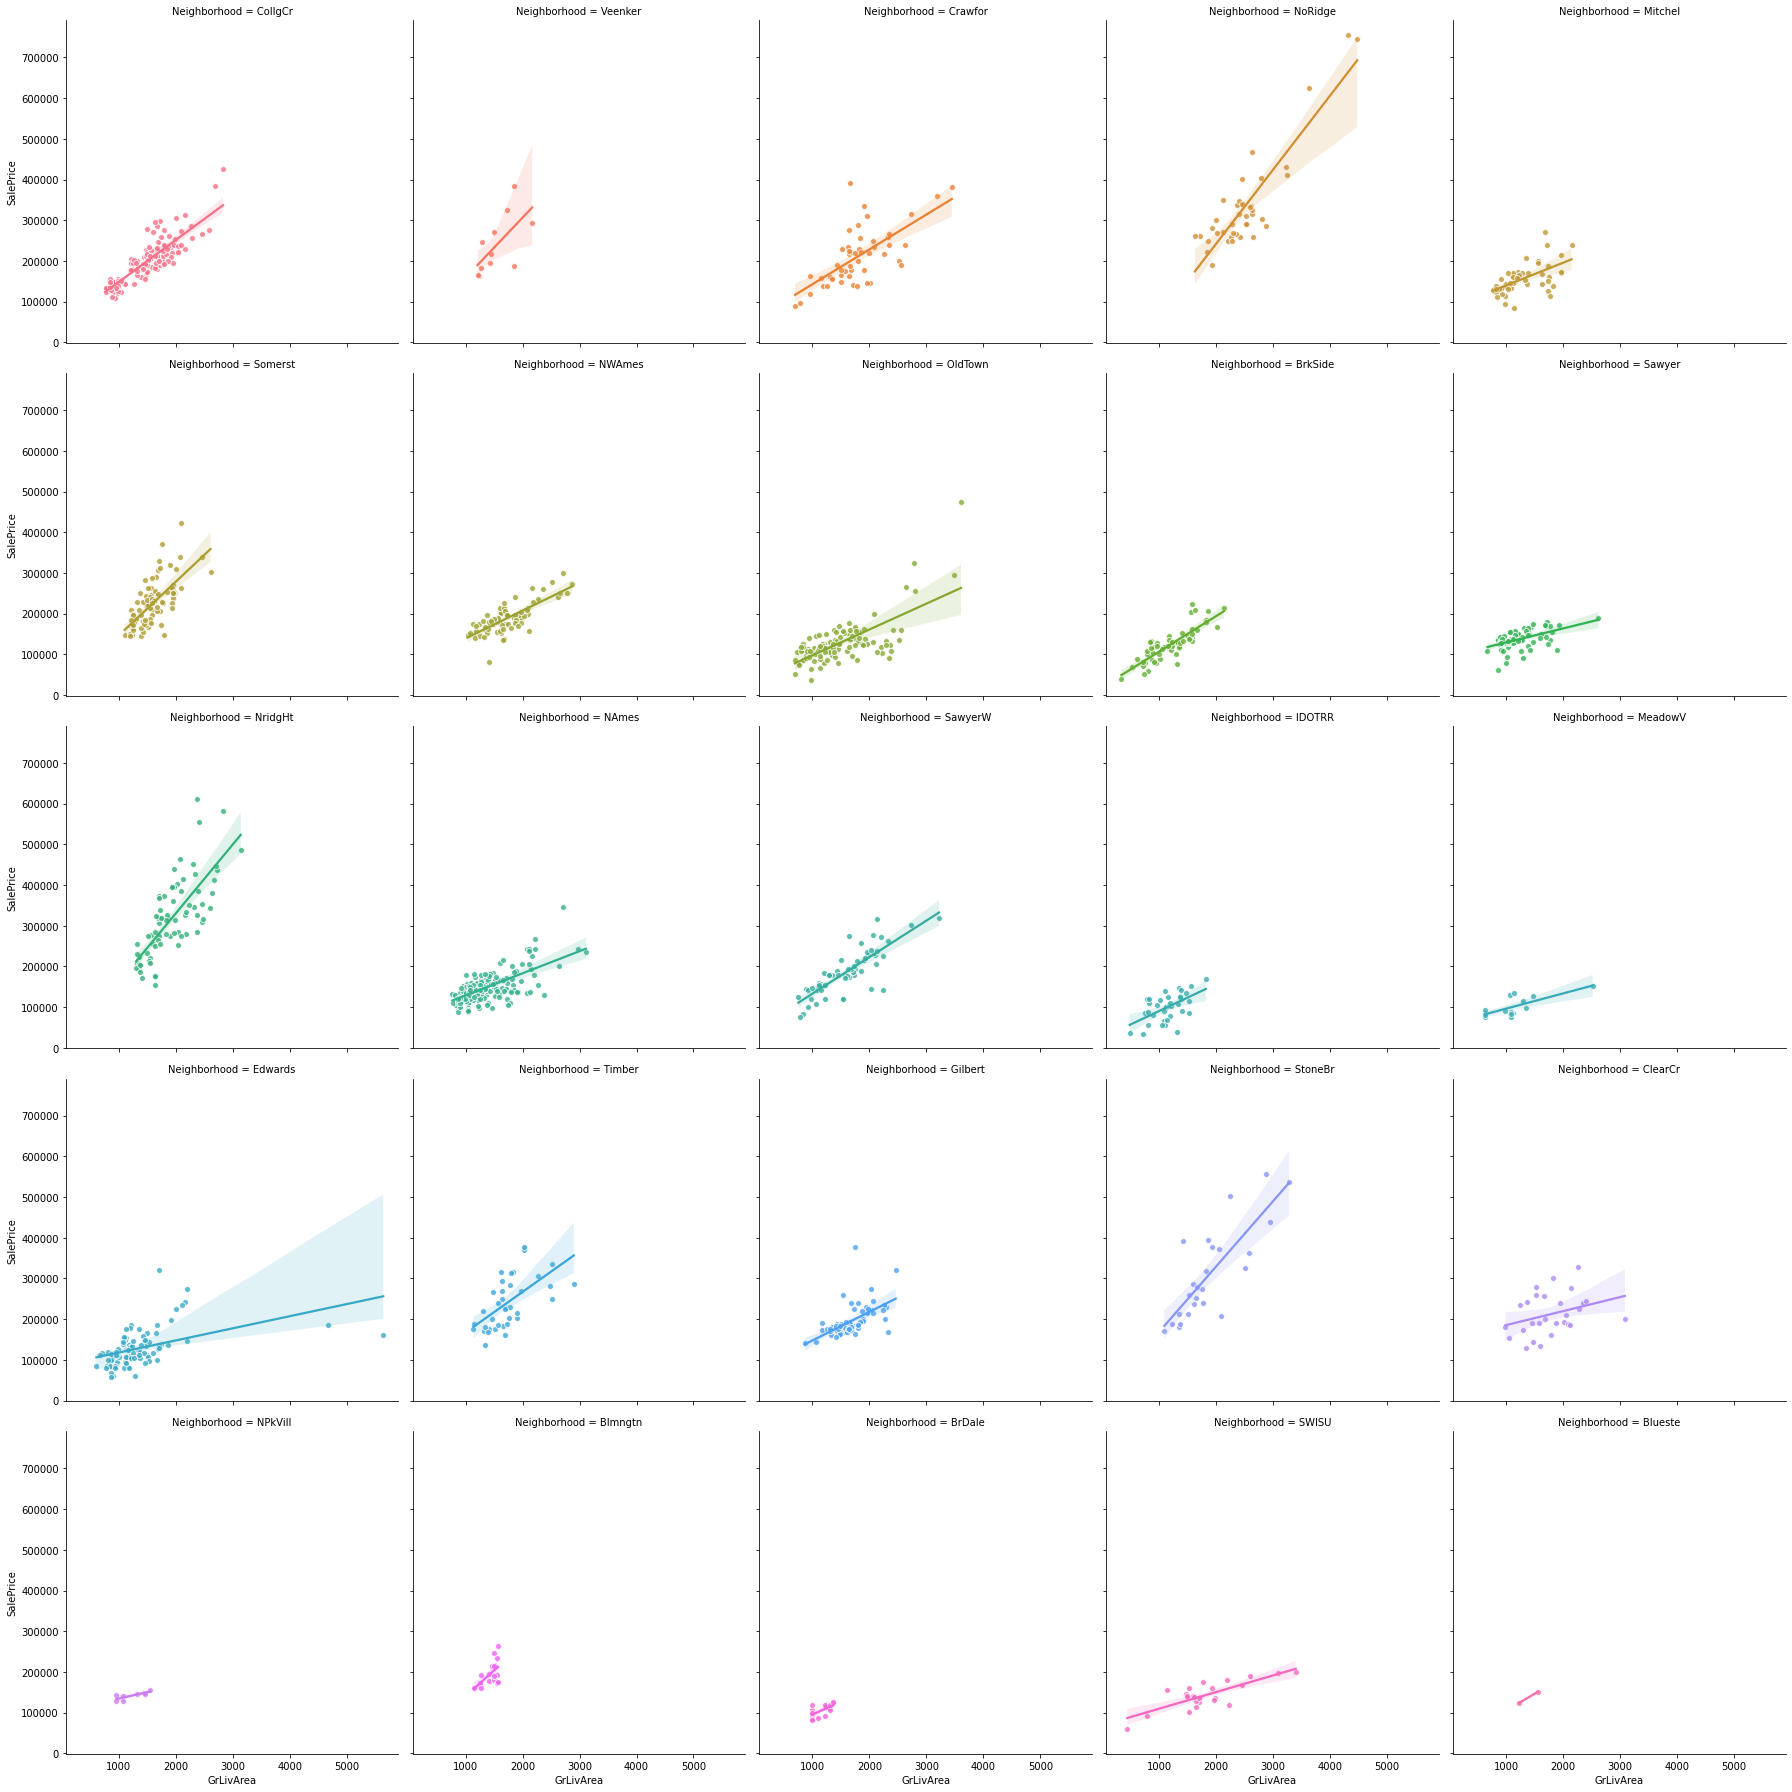

In [16]:
sns.lmplot(x="GrLivArea", y="SalePrice", hue="Neighborhood", col="Neighborhood",
           data=house_data, scatter_kws={"edgecolor": 'w'}, col_wrap=5,
          )

In [17]:
house_data["MedNhbdArea"] = house_data.groupby("Neighborhood")["GrLivArea"].transform("median")

In [18]:
show_data(house_data)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Spaciousness,LivLotRatio,TotalOutsideSF,Bldg_1Fam,Bldg_2fmCon,Bldg_Duplex,Bldg_Twnhs,Bldg_TwnhsE,Garage_2Types,Garage_Attchd,Garage_Basment,Garage_BuiltIn,Garage_CarPort,Garage_Detchd,PorchTypes,MedNhbdArea
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,213.750000,0.202367,609,1710,0,0,0,0,0,548,0,0,0,0,1,1500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,210.333333,0.131458,758,1262,0,0,0,0,0,460,0,0,0,0,1,1437.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,297.666667,0.158756,650,1786,0,0,0,0,0,608,0,0,0,0,1,1500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,245.285714,0.179791,949,1717,0,0,0,0,0,0,0,0,0,642,2,1717.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,244.222222,0.154137,1112,2198,0,0,0,0,0,836,0,0,0,0,2,2418.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,235.285714,0.208033,500,1647,0,0,0,0,0,460,0,0,0,0,1,1593.0
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlo

### Adding all new features to `test_data`

In [19]:
test_data["Spaciousness"] = test_data[["1stFlrSF", "2ndFlrSF"]].sum(axis=1) / test_data.TotRmsAbvGrd
test_data["LivLotRatio"] = test_data["GrLivArea"] / test_data["LotArea"]
test_data["TotalOutsideSF"] = test_data[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "GarageArea"]].sum(axis=1)

# Categorical and numerical col relation
x = pd.get_dummies(test_data["BldgType"], prefix="Bldg")
# Multiply
x = x.mul(test_data["GrLivArea"], axis=0)

# Categorical and numerical col relation
y = pd.get_dummies(test_data["GarageType"], prefix="Garage")
# Multiply
y = y.mul(test_data["GarageArea"], axis=0)
test_data = test_data.join(x)
test_data = test_data.join(y)

test_data["PorchTypes"] = test_data[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]].gt(0).sum(axis=1)
test_data["MedNhbdArea"] = test_data.groupby("Neighborhood")["GrLivArea"].transform("median")

## 3. Check Mutual Information

In [20]:
def impute_data(data, *, num_strategy="mean", cat_strategy="most_frequent"):
    data = data.copy()
    index = data.index
    num_cols = data.select_dtypes(exclude="object").columns
    cat_cols = data.select_dtypes("object").columns
    
    num_imputer = SimpleImputer(strategy=num_strategy)
    cat_imputer = SimpleImputer(strategy=cat_strategy)
    
    data[num_cols] = pd.DataFrame(num_imputer.fit_transform(data[num_cols]), index=index, columns=num_cols)
    data[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(data[cat_cols]), index=index, columns=cat_cols)
    return data

In [21]:
def get_mi_score(X, y):
    X = impute_data(X.copy())
    # Converting values of discrete features to numerical values
    for col in X.select_dtypes(["object"]):
        X[col] = X[col].factorize()[0]
    
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    return mi_scores

In [22]:
X = house_data
y = X.pop("SalePrice")
mi_scores = get_mi_score(X, y)
mi_scores.head(20)

OverallQual       0.570371
Neighborhood      0.532801
GrLivArea         0.480032
MedNhbdArea       0.475657
Bldg_1Fam         0.435088
YearBuilt         0.373786
TotalBsmtSF       0.366680
GarageArea        0.361486
TotalOutsideSF    0.359785
Garage_Attchd     0.354816
GarageCars        0.354614
ExterQual         0.334023
KitchenQual       0.328130
1stFlrSF          0.309209
BsmtQual          0.306412
GarageYrBlt       0.305727
MSSubClass        0.270840
FullBath          0.250156
YearRemodAdd      0.249066
Spaciousness      0.247430
Name: MI Scores, dtype: float64

In [23]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(10, 6))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.tight_layout()

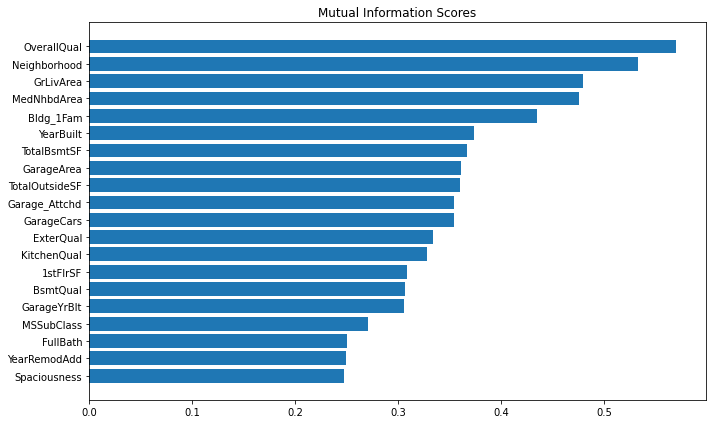

In [24]:
plot_mi_scores(mi_scores.head(20))

## 4. Selecting useful features

In [25]:
useful_features = mi_scores[:85].index
X = house_data[useful_features]
test = test_data[useful_features]
useful_features

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'MedNhbdArea', 'Bldg_1Fam',
       'YearBuilt', 'TotalBsmtSF', 'GarageArea', 'TotalOutsideSF',
       'Garage_Attchd', 'GarageCars', 'ExterQual', 'KitchenQual', '1stFlrSF',
       'BsmtQual', 'GarageYrBlt', 'MSSubClass', 'FullBath', 'YearRemodAdd',
       'Spaciousness', 'GarageFinish', 'TotRmsAbvGrd', 'Foundation',
       'LotFrontage', '2ndFlrSF', 'Fireplaces', 'HeatingQC', 'Exterior2nd',
       'LotArea', 'Garage_Detchd', 'BsmtFinSF1', 'OpenPorchSF', 'BsmtFinType1',
       'Exterior1st', 'MSZoning', 'OverallCond', 'BsmtUnfSF', 'GarageType',
       'PorchTypes', 'WoodDeckSF', 'MasVnrArea', 'MasVnrType', 'LotShape',
       'LivLotRatio', 'FireplaceQu', 'SaleType', 'SaleCondition', 'HouseStyle',
       'BedroomAbvGr', 'Garage_BuiltIn', 'HalfBath', 'CentralAir',
       'BsmtExposure', 'Electrical', 'Bldg_TwnhsE', 'PavedDrive', 'BldgType',
       'BsmtFullBath', 'EnclosedPorch', 'LandContour', 'Bldg_Duplex',
       'BsmtCond', 'Condition

## 5. Extracting numerical and categorical columns

In [26]:
X.dtypes.value_counts()

object     41
int64      38
float64     6
dtype: int64

In [27]:
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes("object").columns

## 6. Creating Pipeline

In [28]:
class CreatePipeline:
    """Create Pipeline
    methods:
        pipeline: Create Final Pipeline
        
        create_model: Create the provided model
        
        numerical_transformer: Transform numerical cols
        
        categorical_transformer: Transform categorical cols \
        OneHotEncoding / OrdinalEncoding
        
        data_preprocessor: Preprocess the data using ColumnTransformer     
        """
    
    def pipeline(self, *, preprocessor, model, verbose=False):
        """Creates pipeline
        params:
            preprocessor
            model
        """
        steps = [("preprocessor", preprocessor),
                 ("model", model)]
        return Pipeline(steps=steps, verbose=verbose)
    
    
    def numerical_transformer(self, *, strategy="mean", **params):
        """Transform numerical columns using `SimpleImputer`.
        params:
            strategy: "mean" | "median" | "most_frequent" | "constant"
            **params: extra keyword args for SimpleImputer"""
        
        transformer = SimpleImputer(strategy=strategy, **params)
        return transformer

    
    def categorical_transformer(self, *, 
                                imp_strategy="most_frequent", 
                                encoder_type="Ordinal", 
                                imp_params={}, encoder_params={}):
        """Transform categorical columns by making Pipeline
        `SimpleImputer` | `OneHotEncoder` | `OrdinalEncoder`.
        args:
            imp_strategy: strategy for imputer values can be
                "most_frequent" | "constant"
            encoder_type: encoder type,
                "Ordinal" | "OneHot"
        kwargs:
            imp_params: keyword args for `SimpleImputer`.
            encoder_params: keyword args for encoder.`
        """
        if not encoder_type in ("Ordinal", "OneHot"):
            raise ValueError(f"Inappropriate value for encoder_type passed: {encoder_type}\
            Takes one of 'Ordinal' | 'OneHot'.")
        
        encoder = OrdinalEncoder if encoder_type=="Ordinal" else OneHotEncoder
        transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy=imp_strategy, **imp_params)),
            (encoder_type, encoder(**encoder_params))
        ])
        return transformer
    
    
    def data_preprocessor(self, *, transformers):
        """Preprocess the data using `ColumnTransformer`.
        Pass extact list of transformers
        to be passed in `ColumnTransformer`.
        each tuple consist of: (transformer_name,
                                transformer,
                                list_of_columns)."""
        preprocessor = ColumnTransformer(transformers=transformers)
        return preprocessor
    
    
    def create_model(self, *, model, random_state=0, n_estimators=1000, **kwargs):
        """Creates the model.
        **kwargs: keyword args for model."""
        my_model = model(random_state=random_state, n_estimators=n_estimators, **kwargs)
        return my_model

In [29]:
cp = CreatePipeline()
num_transformer = cp.numerical_transformer()
cat_transformer = cp.categorical_transformer(encoder_params={"handle_unknown":"use_encoded_value", "unknown_value":-1})

preprocessor = cp.data_preprocessor(
    transformers=[("num", num_transformer, num_cols),
                  ("cat", cat_transformer, cat_cols)
                 ])

## 7. Doing hyperparameter tuning with cross-validation

In [30]:
n_estimators = [500, 750, 1000]
learning_rate = [0.05, 0.1]
maes = {}
i = 0
for n in n_estimators:
    for rate in learning_rate:
        i += 1
        model = cp.create_model(model=XGBRegressor, n_estimators=n, learning_rate=rate)
        pipeline = cp.pipeline(preprocessor=preprocessor, model=model)
        scores = -1 * cross_val_score(pipeline, X, y, cv=10, verbose=True,
                                scoring="neg_mean_absolute_error")
        mae = scores.mean()
        maes[i] = [n, rate, mae]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   40.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   57.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


## 8. Checking MAE, selecting best parameters
### n_estimators:`500` and learning_rate:`0.05`
1. N_estimators: 500	Learning rate: 0.05	MAE: 15450
2. N_estimators: 500	Learning rate: 0.1	MAE: 15614
3. N_estimators: 750	Learning rate: 0.05	MAE: 15467
4. N_estimators: 750	Learning rate: 0.1	MAE: 15614
5. N_estimators: 1000	Learning rate: 0.05	MAE: 15481
6. N_estimators: 1000	Learning rate: 0.1	MAE: 15614

In [31]:
for i in maes:
    n_estimators, rate, mae = maes[i]
    print(f"{i}. N_estimators: {n_estimators}\tLearning rate: {rate}\tMAE: {mae:.0f}")

1. N_estimators: 500	Learning rate: 0.05	MAE: 15450
2. N_estimators: 500	Learning rate: 0.1	MAE: 15614
3. N_estimators: 750	Learning rate: 0.05	MAE: 15467
4. N_estimators: 750	Learning rate: 0.1	MAE: 15614
5. N_estimators: 1000	Learning rate: 0.05	MAE: 15481
6. N_estimators: 1000	Learning rate: 0.1	MAE: 15614


In [32]:
best_n_estimators = 500
best_learning_rate = 0.05

## 9. Training model on best parameters

In [33]:
model = cp.create_model(model=XGBRegressor, n_estimators=best_n_estimators, learning_rate=best_learning_rate)
pipeline = cp.pipeline(preprocessor=preprocessor, model=model)
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['OverallQual', 'GrLivArea', 'MedNhbdArea', 'Bldg_1Fam', 'YearBuilt',
       'TotalBsmtSF', 'GarageArea', 'TotalOutsideSF', 'Garage_Attchd',
       'GarageCars', '1stFlrSF', 'GarageYrBlt', 'MSSubClass', 'FullBath',
       'YearRemodAdd', 'Spaciousness', 'TotRmsAbvGrd', 'LotFrontage',
       '2ndFlrSF',...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.05, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=0, num_parallel_tree=1,
                 

## 10. Predicting prices on `test_data`

In [34]:
test_preds = pipeline.predict(test)
test_preds

array([131373.05 , 151797.19 , 190017.84 , ..., 155380.66 , 112549.164,
       205364.17 ], dtype=float32)

## 11. Submitting predicitons

In [35]:
output = pd.DataFrame({"Id": test.index, "SalePrice": test_preds})
output.to_csv("./submission_13.csv", index=False)